In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from collections import deque
import random
import pickle
import pygame
try:
    import gym
except ImportError:
    %pip install gym
    import gym


pygame 2.5.2 (SDL 2.28.3, Python 3.9.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
sns.set_theme(style='whitegrid')
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # else gives error when trying to plot

## 1. Define Environment by Gymnasium

[Environment Details](https://gymnasium.farama.org/environments/classic_control/mountain_car/)

Full Example on Github of the [Mountain Car](https://github.com/guillaumefrd/q-learning-mountain-car)

In [4]:
env = gym.make('MountainCar-v0', render_mode='human')

In [20]:
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")
print(f"Number of actions available: {env.action_space.n}")
print(f"Observation shape: {env.observation_space.shape}")

Action space: Discrete(3)
Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Number of actions available: 3
Observation shape: (2,)


#### <span style="text-decoration:underline;">Explanations:</span>
- Observation space:
    - [-1.2 0.6] position range (in m)
    - [-0.07 0.07] velocity range (in v = m/s)
    - 2dim phase space (x-v-space)
- Actions:
    - 0: Accelerate to left
    - 1: Don't accelerate
    - 2: Accelerate to right
### <span style="text-decoration:underline;">Transition dynamics:</span>
<span style="text-decoration:underline;">Variables:</span>

Force $F$, action $a$, position $x$, velocity $v$, time (discrete) $t$, gravity $g$

The transition dynamics then reads:
$$
\begin{align}
v_{t+1} &= v_t + (a - 1)F - \cos(3x_t)g\\ 
x_{t+1} &= x_t + v_{t+1}
\end{align}
$$

Physical explanation:
- $ (a - 1) \implies$: -1: left, 0; no acceleration; +1: right acceleration; magnitude $F$
- Physically, the dimensions are an acceleration (setting $m=1$ and having a force balance of $\Delta v = v_{t+1}-v_t$)
- The last term is gravitational force, where the angle is expressed as $\alpha=3x$

#### <span style="text-decoration:underline;">Notes</span>
- From what I've seen the default reward setting is -1 per time step where the goal yields 0 reward
- Environment acts stochastically -> require to define bins for space / velocity to assort values to a state

## First steps
- Initialise a random Agent to take random movements
- save duration for each episode -> reward count can be used for this
- Define a run function, to run an agent for $x$ episodes in the environment and to select training and / or rendering

In [71]:
class RandomAgent:
    def __init__(self, input_states):
        self.action_space = env.action_space
        self.states = input_states
        self.pos_space = np.linspace(-1.2, 0.6, self.states)
        self.vel_space = np.linspace(-0.07, 0.07, self.states)

    def observe(self, state, action, next_state, reward, terminated): 
        pass
    
    def select_action(self, state):
        return self.action_space.sample() # take a random action

    def update(self, step_count):
        pass

In [72]:
def run(agent, episodes, render=False, truncate=-1000):
    """
    Run the Agent through the environment
    :param episodes: number of episodes to run the algorithm
    :param render: boolean to render the environment or not
    :param truncate: truncate the episode if it is too long, set as 1000 steps -> noting reward = -1 per step except goal state
    :return: rewards_per_episode: rewards obtained per episode
    """
    
    # load the environment and discretize the state space
    env = gym.make('MountainCar-v0', render_mode='human' if render else None)

    # memory for rewards per episode
    rewards_per_episode = np.zeros(episodes)

    step_count = 0 # tracking the number of steps taken in the environment -> used for syncing policy_net -> target_net 
    
    for i in range(episodes):
        state = env.reset()[0] # reset to initial state
        rewards = 0
        
        # discretize the state space and overwrite the state
        state_p = np.digitize(state[0], agent.pos_space)
        state_v = np.digitize(state[1], agent.vel_space)
        state = [state_p, state_v]

        terminated = False 

        while not terminated:
            action = agent.select_action(state) # select action based on agent's policy
            next_state, reward, terminated, _, _ = env.step(action) # take action 

            agent.observe(state, action, next_state, reward, terminated) # update agent's memory -> add to replay buffer
            # discretize next state and update state
            next_state_p = np.digitize(next_state[0], agent.pos_space) 
            next_state_v = np.digitize(next_state[1], agent.vel_space)
            next_state = [next_state_p, next_state_v]

            agent.update(step_count) # update agent's policy based on observed transition

            state = next_state # update state

            rewards += reward # accumulate rewards
            step_count += 1
            # truncate the episode if it is too long, set as 1000 steps -> noting reward = -1 per step except goal state
            if rewards < truncate:
                break 
            
        rewards_per_episode[i] = rewards # store rewards per episode
    
    env.close()
    return rewards_per_episode

c:\Users\Lione\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


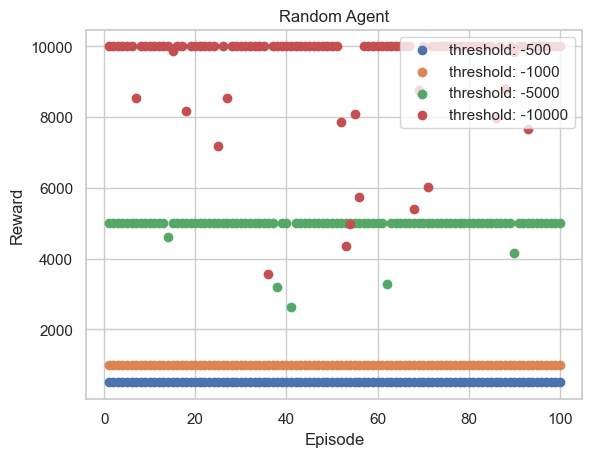

In [73]:
# run the random Agent 100 times and plot rewards
random_agent = RandomAgent(input_states=20)
truncate_list = [-500, -1000, -5000, -10000]
steps = []

fig, ax = plt.subplots()

for truncate in truncate_list:
    rewards = run(random_agent, 100, truncate=truncate)
    steps.append(np.abs(rewards))

    # plot steps taken of current episode
    ax.scatter(np.arange(1, 101), np.abs(rewards), label=f'threshold: {truncate}')

#ax.hlines(np.abs(5000), 0, 100, colors='red', linestyles='dashed', label='threshold') --> In case we want to plot a threshold line
ax.set(xlabel='Episode', ylabel='Reward', title='Random Agent')

plt.legend()
plt.show()

In [8]:
#run(random_agent, 1, render=True) --> In case we want to render the environment

## 2. Define NN class, to initialise for DQN with tunable hidden layers and neuron number

In [74]:
# Define Network class for DQN with 1 hidden layer and relu activation
class DQN(nn.Module):
    def __init__(self, input_states, out_actions, hidden_layers=2, hidden_nodes=64):
        super(DQN, self).__init__()

        self.hidden_layers = nn.ModuleList([nn.Linear(input_states, hidden_nodes)])
        self.hidden_layers.extend([nn.Linear(hidden_nodes, hidden_nodes) for i in range(hidden_layers-1)])
        self.out = nn.Linear(hidden_nodes, out_actions)
    
    def forward(self, x):
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        x = self.out(x)
        return x

## 3. Define Agent

In [75]:
def state_to_tensorstate(state)->torch.Tensor:
    """
    Convert state to tensor state for input to the network
    :param state: state to convert - Note that the digitized state is required here
    :param pos_space: position space
    :param vel_space: velocity space
    :return: tensor state
    """

    input_tensor = torch.zeros(len(pos_space) ** 2)
    state_index = x_index * len(pos_space) + v_index
    input_tensor[state_index] = 1 # one hot encoding of state
    return input_tensor


In [179]:
class DQNAgent:
    def __init__(self, Q, gamma, epsilon, R, batch_size, learning_rate, sync_rate, input_states=20, optimizer=optim.AdamW): 
        # Initialize agent
        self.action_space = env.action_space
        self.optimizer = optimizer(Q.parameters(), lr=learning_rate)
        self.memory = deque([], maxlen=R) # replay buffer
        self.epsilon = epsilon # exploration rate
        self.gamma = gamma # discount factor
        self.batch_size = batch_size # batch size for training
        self.states = env.observation_space.shape[0] # number of states
        self.sync_rate = sync_rate # rate at which to sync policy network with target network  
        self.loss = nn.MSELoss() # loss function
        self.pos_space = np.linspace(-1.2, 0.6, input_states) # discretized position space
        self.vel_space = np.linspace(-0.07, 0.07, input_states) # discretized velocity space
        
        # Initialize Q-networks
        self.policy_net = Q
        self.target_net = Q
        
    def observe(self, state, action, next_state, reward, terminated):
        # Update agent's internal memory with observed transition
        self.memory.append((state, action, next_state, reward, terminated))
        
    def select_action(self, state):
        # Select action based on epsilon-greedy policy -> returns action
        if np.random.rand() < self.epsilon: # explore with probability epsilon
            action = self.action_space.sample()
        else:
            with torch.no_grad(): # no need to calculate gradients
                state_tensor = torch.FloatTensor([state])
                action = torch.argmax(self.policy_net(state_tensor)).item() # exploit with probability 1-epsilon from policy network
                
        return action
        
    def update(self, t):
        # Update agent's policy based on observed transitions

        # sync policy network with target network each sync_rate steps
        if t>=self.sync_rate:
            self.target_net.load_state_dict(self.policy_net.state_dict())
            t = 0

        Q_current_list = []
        Q_target_list = []

        if (len(self.memory) > self.batch_size): # return if not enough samples in memory
            mini_batch = random.sample(self.memory, self.batch_size) # sample mini-batch from memory
            for state, action, next_state, reward, terminated in mini_batch:
                # set target to be the reward + discounted future reward
                if terminated:
                    target = torch.FloatTensor([reward]) # if terminated, target is the reward!
                else:
                    with torch.no_grad():
                        next_state_tensor = torch.FloatTensor([next_state])
                        target = reward + self.gamma * torch.max(self.target_net(next_state_tensor))# target is reward + discounted future reward

                # calculate the current Q-value and target Q-value 
                Q_current = self.policy_net(torch.FloatTensor([state])) # current Q-value
                Q_current_list.append(Q_current)

                Q_target = self.target_net(torch.FloatTensor([state]))
                Q_target[0, action] = target 
                Q_target_list.append(Q_target.detach())

            # calculate loss and update policy network

            loss = self.loss(torch.stack(Q_current_list), torch.stack(Q_target_list))
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            



In [180]:
# Initialize DQN agent + network
Q = DQN(input_states=2, out_actions=env.action_space.n, hidden_layers=2, hidden_nodes=64)
dqn_agent = DQNAgent(Q=Q, gamma=0.99, epsilon=0.9, R=10000, batch_size=32, learning_rate=0.001, sync_rate=1000)

rewards = run(dqn_agent, 5)


In [171]:
env.observation_space.shape[0]

2

In [172]:
print(rewards)

[-1001. -1001. -1001. -1001. -1001.]


## Implementation Q-learning (Example)

c:\Users\Lione\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


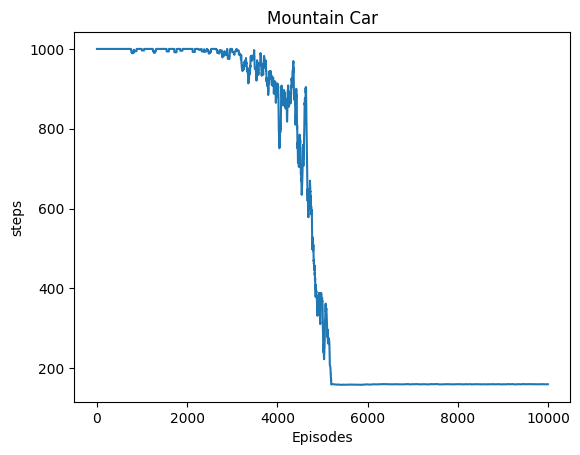

In [ ]:
# Example for normal Q-learning without specifying agent class

def run(episodes, is_training=True, render=False): 
    """""""""
    Run Q-learning algorithm for MountainCar environment

    :param episodes: number of episodes to run the algorithm

    :param render: boolean to render the environment or not

    :return: None

    """""""""


    env = gym.make('MountainCar-v0', render_mode='human' if render else None)

    # divide position and velocity into 20 segments -> 20 states for each
    pos_space = np.linspace(-1.2, 0.6, 20)
    vel_space = np.linspace(-0.07, 0.07, 20)

    # if training initialize Q-table with zeros else load Q-table from file from trained model
    if is_training:
        q = np.zeros((len(pos_space), len(vel_space), 3)) # initialize Q-table with zeros -> 20x20x3; 3 from action space
    else:
        f = open('mountain_car.pkl', 'rb') # open file in read mode
        q = pickle.load(f)
        f.close()
    # hyperparameters
    learning_rate = 0.9
    discount_factor = 0.95
    epsilon = 1 # exploration rate -> start at 100% exploration
    epsilon_decay =  2 / episodes # at 50% of episodes epsilon will be 0 -> only exploitation

    rng = np.random.default_rng() # random number generator, generates numbers in range [0.0, 1.0)

    # memory for rewards per episode
    rewards_per_episode = np.zeros(episodes)

    for episode in range(episodes):
        state = env.reset()[0] # reset environment and get initial state of the car as a numpy array
        state_p = np.digitize(state[0], pos_space)
        state_v = np.digitize(state[1], vel_space)

        terminated = False # initialize terminated to False -> goal is not reached

        rewards = 0 # initialize rewards to 0
        
        while(not terminated and rewards>-1000): # loop until goal is reached or rewards are less than -1000 (to avoid infinite loop)

            # select action with epsilon-greedy policy
            if is_training and rng.random() < epsilon: # if not training take greedy action
                action = env.action_space.sample() # take random action
            else:
                action = np.argmax(q[state_p, state_v, :]) # take action with highest Q-value == greedy action

            # observe the next state and reward put in the right state with digitize using epsilong greedy policy
            # NOTE: digitize returns the index of the bin to which each value belongs
            next_state, reward, terminated, _, _ = env.step(action)
            next_state_p = np.digitize(next_state[0], pos_space)
            next_state_v = np.digitize(next_state[1], vel_space)

            # update Q-table with Q-learning -> updates with greedy policy -- only if training
            if is_training:
                q[state_p, state_v, action] = q[state_p, state_v, action] + \
                learning_rate * (reward + discount_factor * np.max(q[next_state_p, next_state_v, :]) - q[state_p, state_v, action])

            # update state and rewards
            state = next_state
            state_p = next_state_p
            state_v = next_state_v
            rewards += reward

        # update epsilon
        epsilon = max(0, epsilon - epsilon_decay) # ensure epsilon is not negative

        rewards_per_episode[episode] = rewards # store rewards for this episode
    
    env.close()

    # Save Q-table
    if is_training:
        f = open('mountain_car.pkl','wb') # open file in write mode
        pickle.dump(q, f)
        f.close()
    
    mean_rewards = np.zeros(episodes)
    for i in range(episodes):
        mean_rewards[i] = np.mean(rewards_per_episode[max(0, i-50):i+1]) # calculate mean rewards for last 100 episodes -> batches of size 100 to get rewards
    steps_used = np.abs(mean_rewards)
    plt.plot(steps_used)
    plt.xlabel('Episodes')
    plt.ylabel('steps')
    plt.title('Mountain Car')
    plt.show()
    #plt.savefig('mountain_car.png')
run(10000, render=False)


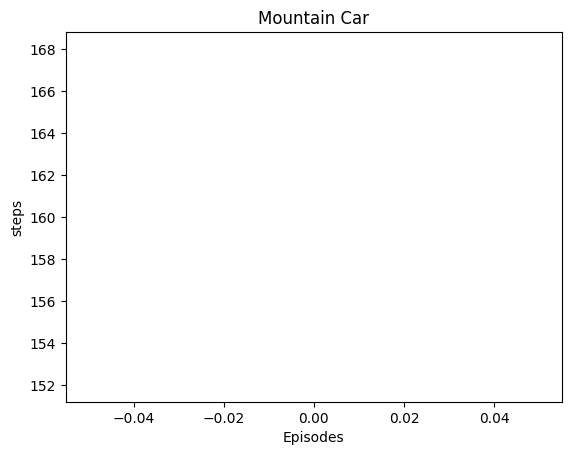

In [ ]:
# run the trained model
run(1, is_training=False, render=True)